In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import ast
from tqdm import tqdm
import scipy
from scipy.sparse import csr_matrix
from scipy.stats import rankdata
from tqdm import tqdm
sns.set_context('talk')
%load_ext blackcellmagic

def nd(arr):
    return np.asarray(arr).reshape(-1)

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [25]:
# # Useful dictionary (gene ids to gene name and viceversa)
# gene_ids = pd.read_csv("/home/agalvezm/projects/cca/human/data/adipose/GSM3711757/gene_ids.txt.gz", header = None)
# gene_names = pd.read_csv("/home/agalvezm/projects/cca/human/data/adipose/GSM3711757/genes.txt.gz", header = None)

# gene_id_to_name = dict(pd.concat([gene_ids, gene_names] , axis = 1).values)
# gene_name_to_id = dict(pd.concat([gene_names, gene_ids] , axis = 1).values)

In [5]:
# organ = 'testis'
# # #assignment_type = 'rank_mx'
# # assignment_type = 'rank_mx'



# home = '/home/cellatlas'
# home_output = '/home/agalvezm/projects/cca'
# dicts_path = f"{home_output}/notebooks/files"
# markers_path = f'{home}/human/markers/{organ}/markers.txt'

# tcc_mat_path = f"{home_output}/split_by_celltype/tcc/{organ}"


transcripts_df = pd.read_csv('../files/transcripts.txt', header = None)
transcripts_df.insert(0, column = 'ec', value = transcripts_df.index)
TX_to_ENST = dict(transcripts_df.values)

t2g = pd.read_csv('../files/t2g.txt', sep = '\t', header = None)
ENST_to_ENSG = dict(t2g[[0,1]].values)
ENSG_to_name = dict(t2g[[1,2]].values)

name_to_ENSG = {v: k for k, v in ENSG_to_name.items()}


# Read ENSG_to_ec map
ENSG_to_ecs_df = pd.read_csv('../files/testis_ENSG_to_ecs.tsv', sep = '\t', header = None)

ENSG_to_ecs = dict(ENSG_to_ecs_df.values)

ecs_to_ENSG = {v: k for k, v in ENSG_to_ecs.items()}



# # Get cell types
# celltypes = pd.read_csv(markers_path, sep = '\t', header = None)[0].values


# # genes_results_folder = f'/home/agalvezm/projects/cca/isoform_gene_de/genes_ttest'
# # isoforms_results_folder = f'/home/agalvezm/projects/cca/tcm_ttests'

In [6]:
# expression_folder = "/home/agalvezm/projects/cca/expression"
# exp_fname = "transcript/oas1_all_isof/metadata_expression.csv"

In [7]:
# Dictionary from transcript id to isoform common name

id_to_name = {'ENST00000445409.6': 'p48',
 'ENST00000452357.6': 'p42',
 'ENST00000202917.10': 'p46',
 'ENST00000551241.5': 'p44b',
}

In [9]:
df

,Unnamed: 0,observation_id,cell_origin,experiment,technology,database_id
0,0,GSM2905292,brain organoid developmental stage: day 32 ste...,protocol: BMPa,10xv2,GSE108571
1,7981,GSM3665019,PBMCs,healthy donor,10xv2,GSE128066
2,11123,GSM4037981,retinal pigment epithelium macula unenriched,donor 1,10xv3,GSE135922
3,16446,GSM3773119,bronchial brushings,current smoker,celseq2,GSE131391
4,16453,GSM3439913,airway epithelial cells,differentiated in BEGM medium,10xv2,GSE121600
...,...,...,...,...,...,...
524,2580755,GSM3711771,stromal vascular fraction. visceral adipose ti...,diabeticand obese individual,10xv2,GSE129363
525,2589783,GSM4272901,trapezius,female. age 62,10xv2,GSE143704
526,2589886,GSM3665017,PBMCs,healthy donor,10xv2,GSE128066
527,2591916,GSM4037316,lung biopsy (multiple locations),healthy,10xv2,GSE135893


In [17]:
#Read dataframe
df = pd.read_csv('../files/oas1_testis_isoform_expression.csv.gz')

# Clean
df = df.drop(columns = ['Unnamed: 0'])

# Replace transcript id by common name
df['target_id'] = [id_to_name[id] if id in id_to_name.keys() else id for id in df['target_id']]

# Create unique cell id
df['cell_id'] = [f"{obs_id}_{bc}" for obs_id, bc in zip(df['observation_id'], df['barcode'])]

# Beautify cell type names
#df['cell_type'] = [ct_names_dict[ct] for ct in df['cell_type']]

df.head(n = 3)

/home/agalvezm/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,expression,target_id,barcode,observation_id,organ,barcodes,label,cell_id
0,0.0,p46,AAACCTGAGAGTTGGC,GSM2905292,brain,AAACCTGAGAGTTGGC,Neurecto-epithelial cell,GSM2905292_AAACCTGAGAGTTGGC
1,0.0,p48,AAACCTGAGAGTTGGC,GSM2905292,brain,AAACCTGAGAGTTGGC,Neurecto-epithelial cell,GSM2905292_AAACCTGAGAGTTGGC
2,0.0,p42,AAACCTGAGAGTTGGC,GSM2905292,brain,AAACCTGAGAGTTGGC,Neurecto-epithelial cell,GSM2905292_AAACCTGAGAGTTGGC


In [18]:
order = ['p42', 'p44b', 'p46', 'p48', 'ENST00000553185.1',
       'ENST00000553152.1', 'ENST00000552526.1', 'ENST00000550883.1',
       'ENST00000550689.1', 'ENST00000549820.1', 'ENST00000540589.2']

pal = sns.color_palette("Blues")


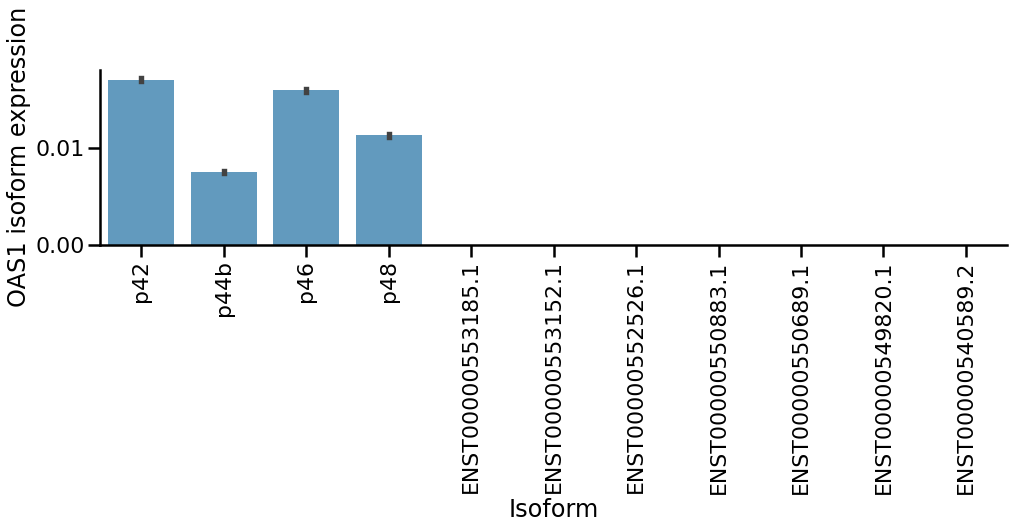

In [20]:
toplot_df = df

plt.subplots(figsize=(15,7))
sns.set_context('poster')
f = sns.barplot(y = toplot_df['expression'], x = toplot_df['target_id'], 
                order = order, palette = [pal[3]] *4 + ['gray'] * 7)
f.set_xlabel("Isoform")
f.set_ylabel('OAS1 isoform expression')
plt.xticks(rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig('figures/all_OAS1_isoforms_expression_atlas.png')